# Overfitting of DenseNN on the IMDB movie reviews dataset

In this notebook we shall focus on overfitting of Dense NNs, showing it and studying techniques to reduce it.

As specific example, we see the classification on the IMDB movie reviews dataset.

The IMDB movie reviews dataset consists of 25,000 movies reviews: each review is a text (i.e. sequence of words). Each review is labeled by $0$/$1$, which means negative/prositive review. The aim is to learn a classifier NN: it is a binary classifier, the output is either $0$/$1$.

This particular binary classification problem can be called as "sentyment analysis", since the aim is to classify the reviews according to their associated sentyment: either positive or negative.

In [2]:
from keras.layers import Input, Dense  # Import the layers for the network
from keras.models import Model  # Import the class for creating the network
from keras.datasets import imdb  # Import the dataset
import matplotlib.pyplot as plt  # For plotting
import numpy as np

## LOAD THE DATASET

Let us load the dataset. In keras, the dataset is preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. 

So, let's load the IMDB dataset.

Se dataset is represented in the following way. There are $50000$ movie reviews. Each movie review is a text, i.e. a sequence of words. So, each review is a list of words.

The words are actually represented as numbers. Numbers in the range $[1, N]$, where $N$ is the number of different words in all the possible reviews. So, a review is a list of natural numbers in the range $[1,N]$.

How this encoding words $\mapsto$ numbers is built? Basically, the $N$ possible different words words are sorted by their frequency in the all the possible reviews. Then, the mapping to natural numbers is built: the first word corresponds to the number $1$; the second word corresponds to the number $2$; the third word corresponds to the number $3$; ... .

Basically, the most frequent word is encoded as $1$; the second most frequent word is encoded as $2$; ... .

In downloading the IMDB dataset, we can ask to keep only the $M$ most frequent words: all the other $N-M$ words are simply discarded. Basically, we keep only the integers which are $<=M$

So, each review is a list of natural numbers in the range $[1,M]$.

In our case, we ask to keep only the $M=500$ most frequent words.

In [3]:
M = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=M)

17473536/17464789 [==============================] - 3s 0us/step


The downloaded is already splitted into train-test.

In [4]:
print('Training shape', x_train.shape)
print('Test shape', x_test.shape)

Training shape (25000,)
Test shape (25000,)


Half of the instances are in the training set, half in the test set.

### Features data x

Each review is a list of natural numbers in the range $[1,500]$. 

Let's see the first review.

In [5]:
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


The lengths of different reviews can be different (different number of words).

### Target vector y

Each review is labeled as positive/negative ($1$/$0$): this is the sentyment of the review.

In [6]:
print(y_train[0])

1


The first review has a positive sentyment.

## PRE-PROCESSING

Our dataset needs some pre-processing. In particular, the features data `x`.

Indeed, the current representation of a review is as a list of numbers. We don't like this representation because it has a variable length: the different reviews can have different lengths, different number of elelements.

We change the representation of the reviews: we change to the bag of words representation.

### Bag of words representation

Let $M$ be the number of possible different words (in our case $M=500$), represented as the numbers $1, 2, ..., M$.

Each review is represented as a list of $M$ values. Each value is either $0$ or $1$. If the $i$-th value of this review is $0$, this means that the word $i$ is not present in that review. Otherwise, if the $i$-th value of this review is $1$, this means that the word $i$ is present in that review.

Basically, a review is a vector of $0$/$1$ which tell us which words are contained in the review and which words are not.

Actually, since in Python the indeces of a list start from $0$, the indeces of a review are $0, 1, ..., M-1$: this means that the value at index $i$ refers to the word $i+1$.

All the reviews are represented in such way. So, all the reviews have now the same size: each review has $M$ values.

On the whole, we have a matrix in which the rows are the different reviews and in which the columns are the different words $1, 2, ..., M$. (Actually, $0, 1, ..., M$).

Value at indeces $i,j$: if $0$, the review $i$ does not contain the word $j+1$; if $1$, the review $i$ does contain the word $j+1$.

**Bag of words representation: matrix with values $0$/$1$, which has as many rows as the different reviews and as many columns as the different possible worlds.**

Both the reviews (i.e. the rows) and the words (i.e. columns) are indexed starting from $0$.

We tranform in this way both the training `x_train` and the test `x_test`.

### Function for the pre-processing

We write a function for transforming the actual representation of the reviews into the bag of words representation.

In [7]:
def transform_into_bagOfWords(reviews, M):
  """
  Transforms the current reviews representation into the bag of words representation
  
  Arguments
  ---------
      - reviews: list of lists
        List containing all the reviews. Each review is a list of natural numbers, representing words.
      - M: int
        Number of possible different words
        
  Return
  ---------
  bag_of_words: np.array
  Two-dimensional array (i.e. matrix). Bag of words matrix.
  """
    
  n_reviews = len(reviews)  # Number of reviews

  # Bag of words matrix. Size n_reviews*M.
  # Rows: 0, 1, ..., n_reviews
  # Columns: 0, 1, ..., M
  # This matrix is initialized to 0
  bag_of_words = np.zeros((n_reviews, M))
    
  # We iterate over all the reviews: from review 0 to review n_reviews-1
  for i in range(0, n_reviews):
    # Current review: review 'i'.
    # reviews[i] is the list of words contained in that review.
    # We take the row 'i' of the bag of words and we have to put to 1 all the columns corresponding to the words in 
    # reviews[i]. 
    # We can access to the row 'i' and to all the columns with indeces in reviews[i] by simply writing
    #                        bag_of_words[i, reviews[i]]  (we are accesssing with a list of integers the column dimension)
    bag_of_words[i, reviews[i]] = 1
    
  return bag_of_words

### Tranforming the dataset

We tranform both the training `x_train` and the test `x_test`.

In [8]:
x_train = transform_into_bagOfWords(x_train, M)
x_test = transform_into_bagOfWords(x_test, M)

Let us have a look at the initial part (only first 30 words) of the encoding for the first review.

In [9]:
print(x_train[0,0:30])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0.]


## FIRST NEURAL NETWORK

### Define the NN

We now define our first model, which is a dense NN. It is just a concatenation of three dense layers.

The input layer has $M=500$ nodes, since each review is a vector of $M$ values (flat vector). 

The first hidden dense layer has $64$ nodes (hyperparameter) with relu activation function (hyperparameter). The second hidden dense layer has $16$ nodes (hyperparameter) with relu activation function (hyperparameter).

The output layer has only one node/output, which represents the probability that the review belongs to the class $1$, which is the class positive. Since there is only one output, the activation function is sigmoid (it ensures me that the output is between $0$ and $1$, i.e. a probability value). Binary classification problem.

In [11]:
xin = Input(shape=(M,))
x = Dense(64, activation='relu')(xin)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(xin, x)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________


In the summary we can see that we have four layers.
1. Input layer. $500$ nodes. No parameters.
2. Hidden layer. It is a dense layer. $64$ nodes. $501*64=32064$ parameters. (Each node has 500 inputs and 1 bias).
2. Hidden layer. It is a dense layer. $16$ nodes. $65*16=1040$ parameters. (Each node has 64 inputs and 1 bias).
3. Output layer. It is a dense layer. $1$ node. $17*1=17$ parameters. (Each node has 16 inputs and 1 bias).

On the whole, $33121$ parameters.

### Compile the NN

We use adam as optimizer.

We use binary crossentropy as loss function: it measueres the distance between the true label of the review (i.e. either $0$/$1$) and the output of the NN, which is the probability of belonging to class $1$. Binary crossentropy this is the loss function which is typically used when the output of the NN is a single value that is a probability value. 

We also specify the 'accuracy' as additional measure for monitoring the training process.

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the NN

Finally, we fit the model over the training set. 

Fitting just requires two arguments: training data and ground truth, that is x and y. Additionally we can specify the number of epochs, the size of the mini batch, and many additional arguments.

In particular, passing validation data allow the training procedure to measure loss and metrics on the test set at the end of each epoch.

In [14]:
training_history = model.fit(x_train, y_train, epochs=6, batch_size = 512, validation_data = (x_test, y_test),
                                  verbose=1)

Epoch 1/6
49/49 [==============================] - 1s 5ms/step - loss: 0.5250 - accuracy: 0.7354 - val_loss: 0.4179 - val_accuracy: 0.8119
Epoch 2/6
49/49 [==============================] - 0s 2ms/step - loss: 0.3878 - accuracy: 0.8277 - val_loss: 0.3873 - val_accuracy: 0.8302
Epoch 3/6
49/49 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8382 - val_loss: 0.3811 - val_accuracy: 0.8319
Epoch 4/6
49/49 [==============================] - 0s 3ms/step - loss: 0.3569 - accuracy: 0.8445 - val_loss: 0.3831 - val_accuracy: 0.8310
Epoch 5/6
49/49 [==============================] - 0s 3ms/step - loss: 0.3459 - accuracy: 0.8495 - val_loss: 0.3854 - val_accuracy: 0.8272
Epoch 6/6
49/49 [==============================] - 0s 3ms/step - loss: 0.3327 - accuracy: 0.8560 - val_loss: 0.3798 - val_accuracy: 0.8303


$6$ epochs. Since the batch_size is $512$, each epoch has $25000/512 = 49$ steps. ($25000$ is the number of samples in the training set).

At the end of each epoch, several information are shown: the time; the loss (on the training data); the accuracy (on the training dat); the loss on the validation data (i.e. test data in this case); the accuracy on the validation data (i.e. test data in this case).

### Analyzing the results

The object returned by the fit method contains the history of the training process. Basically, it contains the `loss`, `accuracy`, `val_loss`, `val_accuracy` with respect to the each epoch.

In [11]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


So, we can make the plot of these scores with respect to the number of epochs.

The following function allows us to plot the results.

In [18]:
def plot_history(training_history, n_epochs):
    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

    plt.figure()
    plt.plot(epochs, training_history.history['accuracy'], label='train_accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Accuracy')

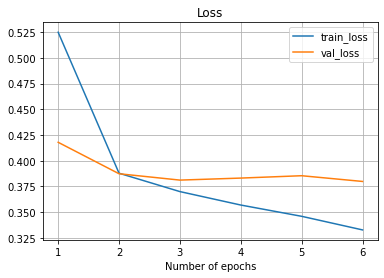

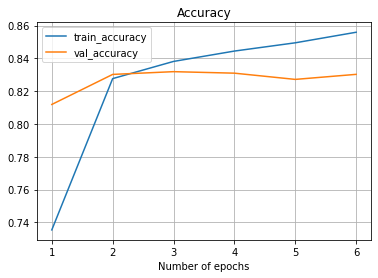

In [19]:
plot_history(training_history, n_epochs=6)

We can see that in the rigth tail (biggest number of epochs, i.e. biggest complexity) the validation score (either loss or accuracy) is worse than using a smaller number of epochs. Basically, the validation score slightly decreases in the right tail. And it is also very oscillating. 

This means that there is a little bit of **overfitting**!!! The model is too complex.

## TECHNIQUES FOR REDUCING OVERFITTING

We will now see some techniques for reducing overfitting.

There are several possible techniques. 

For now, we see only three techniques:
1. Regularization
2. Drop Out
3. Early Stopping

We apply these techniques independently. However, usually (in real life problems) we apply them altogether. We apply more techniques at the same time.  

## REGULARIZATION

### General description

Regularization is a family of techniques which are not used only in NNs, but they are used in general in mathematics and ML. 

The most important regularization technique is **weight decay**, or weigth regularization. It consists in keeping the weights of the NN as small as possible. For doing this, we add to the loss function a regularization component (or error), called weigth decay, which try to reduce the values of the weigths.

There are two classes of weigth decay.
1. L1 regularization. The weigth decay is proportional to $\sum |w_i|$. (Linear, the exponent is $1$). The multiplicative factor is $\lambda$.
2. L2 regularization. The weigth decay component is proportional to $\sum w_i^2$. (Quadratic, the exponent is $2$).  The multiplicative factor is $\lambda$.

So, the weigth decay component is added to the loss function: $Loss = Loss + WeigthDecay$. Since $WightDecay = \sum |w_i|$ or $WightDecay = \sum w_i^2$, and since we want to minimize $Loss$, the result of adding the $WeigthDecay$ is to reduce the magnitude of the weigths.

The bigger $\lambda$, and the bigger is the impact of the $WeigthDecay$ component (i.e. the more the weigths values are reduced).

**Insight**: why are we interested in keeping the values of the weigths as small as possible?
- Ill conditioning problem: the bigger the weigths, the bigger the ill-conditioning of the NN (basically, a small error in the input of the NN generates a big error in the output of the NN).
-If the weigths are big, the gradient of the loss function becomes more and more near $0$: so, the training is much less effective. More useless training.

### Add regularization into our NN

Now we modify our previous NN by adding regularization. 

In keras, we add regularization layer by layer. Basically, we inject regularization into a layer: the effect is that all the weigths in that layer are "regularized". The weight decay is applied to all the weigths in that layer.

The entity that we inject into a layer for the regularization of the weigths is called **regularizer**.

In [21]:
from keras import regularizers  # Import the regularizers

We add into the first hidden layer a L2 regularizer, with $\lambda=0.005$.

We do the same thing also to the second hidden layer.

In [22]:
xin = Input(shape=(M,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(xin)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(xin, x)

### Compile and train the NN

We compile the model as before.

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

We train the model as before.

In [24]:
training_history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_test, y_test),
                             verbose=1)

Epoch 1/5
49/49 - 1s - loss: 1.0533 - accuracy: 0.7116 - val_loss: 0.7706 - val_accuracy: 0.8089 - 1s/epoch - 21ms/step
Epoch 2/5
49/49 - 0s - loss: 0.6606 - accuracy: 0.8231 - val_loss: 0.5969 - val_accuracy: 0.8259 - 284ms/epoch - 6ms/step
Epoch 3/5
49/49 - 0s - loss: 0.5516 - accuracy: 0.8333 - val_loss: 0.5293 - val_accuracy: 0.8309 - 258ms/epoch - 5ms/step
Epoch 4/5
49/49 - 0s - loss: 0.5090 - accuracy: 0.8324 - val_loss: 0.4995 - val_accuracy: 0.8300 - 275ms/epoch - 6ms/step
Epoch 5/5
49/49 - 0s - loss: 0.4806 - accuracy: 0.8369 - val_loss: 0.4787 - val_accuracy: 0.8320 - 350ms/epoch - 7ms/step


### Analyzing the results

Val loss: $0.4787$. Val accuracy: $0.8320$.

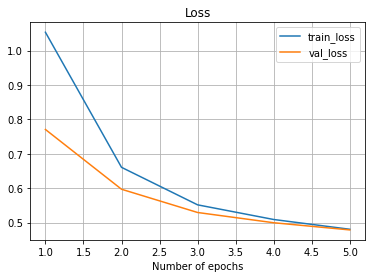

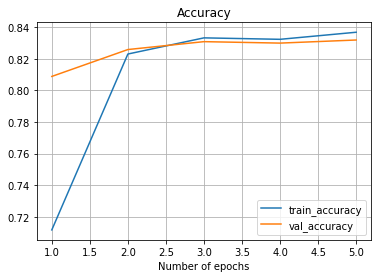

In [26]:
plot_history(training_history, n_epochs=5)

The right tail of the validation score (either loss or accuracy) is much better now! It is closer to the training score and it is much less oscillating (i.e. much more stable).

**We have reduced overfitting!!!**

### Try L1 regularization

We have used L2 regularization. Let's try L2 regularization.

In [50]:
xin = Input(shape=(M,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.005))(xin)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.005))(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(xin, x)

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
training_history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_test, y_test),
                             verbose=1)

Epoch 1/5
49/49 [==============================] - 1s 9ms/step - loss: 6.4133 - accuracy: 0.5701 - val_loss: 3.5891 - val_accuracy: 0.6435
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 2.0755 - accuracy: 0.7243 - val_loss: 1.1231 - val_accuracy: 0.7492
Epoch 3/5
49/49 [==============================] - 0s 7ms/step - loss: 0.9705 - accuracy: 0.7593 - val_loss: 0.8587 - val_accuracy: 0.7599
Epoch 4/5
49/49 [==============================] - 0s 6ms/step - loss: 0.7843 - accuracy: 0.7765 - val_loss: 0.7197 - val_accuracy: 0.7817
Epoch 5/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6701 - accuracy: 0.7976 - val_loss: 0.6314 - val_accuracy: 0.7989


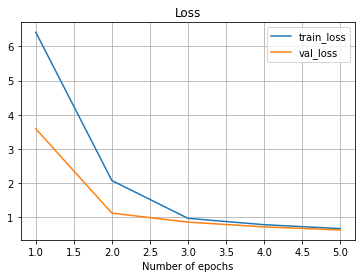

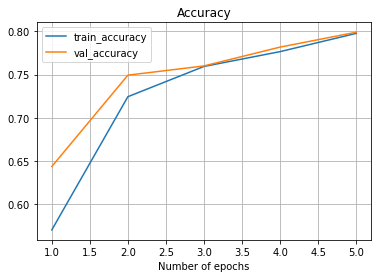

In [53]:
plot_history(training_history, n_epochs=5)

Similar results.

## DROPOUT

### General description

Dropout is an alternative technique for reducing overfitting. It is specific for NNs.

It consists in randomly, with a given certain probability $p$, disabling some neurons of the NN. Basically, each neuron of the NN has probability $p$ of being disabled. $p$ is an hyperparameter of the Drop Out technique.

Let's explain that more precisely.

During training.

In each training step, i.e. forward-backward step, some neurons are randomly disabled, with probability $p$. So, each neuron has probability $p$ of being disabled. 

If a neuron is disabled, this means that it does not impact at all that forward-backward step. It's like that all its outputs are $0$. It's like that it has been removed from the NN.

In different training steps, different neurons are disabled (with same probability $p$).

The weigths of the neurons are updated step by step (as usual). If a neuron is disabled, its weigths are kept as they are. They are not azzerated. So, in the next training step, the update of these weigths can go on.

During prediction time.

All the neurons are kept. All the neurons work. But each neuron is weigthed with $p$.

### Add Drop Out into our NN

Now we modify our previous base NN by adding Drop Out. 

In keras, the Drop Out technique is added layer by layer. Basically, I specify that I apply the Drop Out on the neurons of a certain layer.

More precisely, in keras Drop Out is a layer. It can be inserted between dense layers. The meaning is that the Drop Out technique is applied on the previous dense layer with respect to the Dense Layer. It works on the previous layer.

Many Drop Out layers can be inserted, which means that we apply the Drop Out technique on different dense layers.

In [27]:
from keras.layers import Dropout  # Import the DropOut layer

We add the Drop Out technique to the first hidden dense layer: so, we add the DropOut layer after this hidden layer. 

We do the same with the second hidden dense layer.

In both cases, we use $p=0.5$.

In [28]:
xin = Input(shape=(M,))
x = Dense(64, activation='relu')(xin)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(xin, x)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_9 (Dense)             (None, 64)                32064     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 33,121
Trainable params: 33,121
Non-trainable

In the summary, we can see the two DropOut layers. They don't have any parameter.

### Compile and train the NN

We compile and train the model as before.

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
training_history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
49/49 [==============================] - 1s 10ms/step - loss: 0.6831 - accuracy: 0.5564 - val_loss: 0.6345 - val_accuracy: 0.7303
Epoch 2/5
49/49 [==============================] - 0s 6ms/step - loss: 0.5891 - accuracy: 0.6928 - val_loss: 0.4788 - val_accuracy: 0.8010
Epoch 3/5
49/49 [==============================] - 0s 10ms/step - loss: 0.4956 - accuracy: 0.7687 - val_loss: 0.4137 - val_accuracy: 0.8179
Epoch 4/5
49/49 [==============================] - 0s 7ms/step - loss: 0.4513 - accuracy: 0.7970 - val_loss: 0.3924 - val_accuracy: 0.8259
Epoch 5/5
49/49 [==============================] - 0s 9ms/step - loss: 0.4305 - accuracy: 0.8126 - val_loss: 0.3826 - val_accuracy: 0.8278


### Analyzing the results

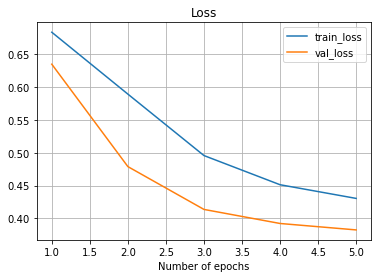

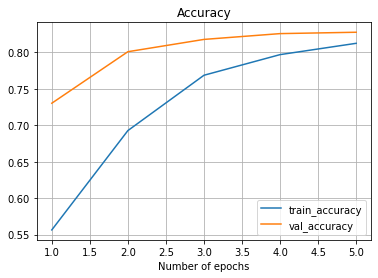

In [33]:
plot_history(training_history, n_epochs=5)

The right tail of the validation score (either loss or accuracy) is much better now! It is better than the training score and it is much less oscillating (i.e. much more stable).

**We have reduced overfitting!!!**

## EARLY STOPPING

### General description

Early stopping is an alternative technique for reducing overfitting. 

It consists in monitoring a certain score measure during training, epoch after epoch. This measure is typically a score measure on the validation set (e.g. 'val_loss', 'val_accuracy'). 

If, at a certain epoch during training, this measure does not improve anymore, then the training is prematurely stopped. The training stops prematurely at that epoch, and it does not continue doing all the number of epochs specified by the user.

To sum up: the training is stopped prematurely if a certain measure (on the validation set) does not improve anymore. 

This technique clearly reduces overfitting, since we reduce the number of epochs. We stop the training as soon as a certain validation score does not improve anymore.

Since there is the early stopping technique, the user can be much more relaxed in defining the number of epochs of the training. It can define also a big number: if the training does not improve our monitored score, the training is prematurely stopped.

### Early Stopping in Keras

In Keras, the early stopping technique is implemented as a **callback** (i.e. function) that can be passed to the `fit` method.

Callback which is called at the end of each epoch, and if the monitored validation score has not improved, the training is stopped.

The user can define his own Early Stopping callback.

But, typically, the Early Stopping callback is defined as an istance of the `EarlyStopping` keras class: this class simplify the creation of Early Stopping callbacks.

Important arguments that must be specified for creating an early stopping callback.
- `monitor`: score measure that must be monitored during training, epoch after epoch.
- `min_delta`: minimum amount of change of the monitored score, with respect to the previous epoch, such that it is considered an improvement.
- `patience`: number of maximum contiguous epochs with no improvement of the monitored score that we can wait before stopping the training.

Let's define our early stopping callback.
- `monitor='val_loss`
- `min_delta=0`
- `patience=3`

In [34]:
from keras.callbacks import EarlyStopping  # Import the EarlyStopping class

early_stop_callback = EarlyStopping(monitor='val_loss', patience=3)  # Default min_delta=0

### Add Early Stopping into our NN

Actually, early stopping does not change the model. It is simply a callback which is passed to the `fit` method.

In [40]:
xin = Input(shape=(M,))
x = Dense(64, activation='relu')(xin)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(xin, x)

### Compile and fit the NN

Compile as before.

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

We pass the early stopping callback to the `fit` method.

Note that now we pass a much bigger number of epochs: `epochs=20`. Thanks to the early stopping, we can be more relaxed in the number of epochs.

In [42]:
training_history = model.fit(x_train, y_train, batch_size=512, epochs=20, verbose=1, validation_data=(x_test,y_test),
          callbacks=[early_stop_callback], shuffle=True)

Epoch 1/20
49/49 [==============================] - 1s 9ms/step - loss: 0.5535 - accuracy: 0.7215 - val_loss: 0.4327 - val_accuracy: 0.8048
Epoch 2/20
49/49 [==============================] - 0s 8ms/step - loss: 0.3974 - accuracy: 0.8247 - val_loss: 0.3937 - val_accuracy: 0.8272
Epoch 3/20
49/49 [==============================] - 0s 7ms/step - loss: 0.3721 - accuracy: 0.8360 - val_loss: 0.3835 - val_accuracy: 0.8325
Epoch 4/20
49/49 [==============================] - 0s 7ms/step - loss: 0.3622 - accuracy: 0.8407 - val_loss: 0.3823 - val_accuracy: 0.8318
Epoch 5/20
49/49 [==============================] - 0s 7ms/step - loss: 0.3569 - accuracy: 0.8430 - val_loss: 0.3902 - val_accuracy: 0.8276
Epoch 6/20
49/49 [==============================] - 0s 7ms/step - loss: 0.3469 - accuracy: 0.8465 - val_loss: 0.3794 - val_accuracy: 0.8326
Epoch 7/20
49/49 [==============================] - 0s 7ms/step - loss: 0.3366 - accuracy: 0.8535 - val_loss: 0.3799 - val_accuracy: 0.8322
Epoch 8/20
49/49 [==

So, the training has been stopped prematurely: epoch $9$ instead of $20$. This because in the last $3$ epochs (i.e. $7, 8, 9$) the `val_loss` has not improved. 

### Analyzing the results

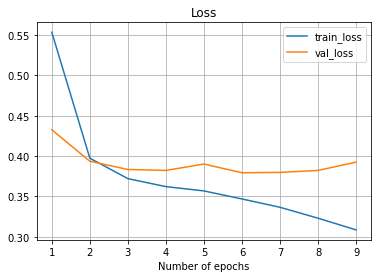

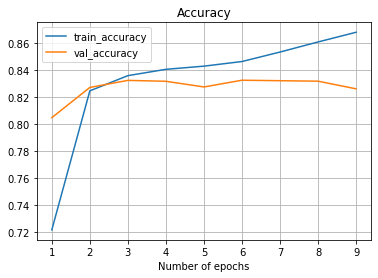

In [44]:
plot_history(training_history, n_epochs=9)

**Some overfitting as been reduced, but not as much with the other two techniques.**